In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import time
import pooch
import anndata as ad

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
path = EXAMPLE_DATA.fetch('s1d1_filtered_feature_bc_matrix.h5')
adata = sc.read_10x_h5(path)
adata.var_names_make_unique()

adata

/home/jasson/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jasson/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8785 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

raw_adata = adata.copy()

In [5]:
dat = pd.DataFrame(
    raw_adata.X.T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
    index=adata.var_names,       # genes
    columns=adata.obs_names      # cells
)

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [7]:
cell_medians = np.median(dat, axis=0)
mask = dat > cell_medians

gene_detected_count = mask.sum(axis=1)

selected_genes = (gene_detected_count >= 10) & (gene_detected_count <= dat.shape[1] * 0.3)

adata = adata[:, selected_genes].copy()
raw_adata = raw_adata[:, selected_genes].copy()
dat = dat[selected_genes]

In [8]:
adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
raw_adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells'

In [10]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import cdist
import networkx as nx
from typing import Tuple, List, Dict, Optional


def find_disconnected_components(A) -> Dict:
    """Find disconnected components in adjacency matrix."""

    if hasattr(A, 'tocsr'):
        A = A.tocsr()
    
    n_components, labels = connected_components(csgraph=A, directed=False, return_labels=True)
    
    components = []
    
    for i in range(n_components):
        component_indices = np.where(labels == i)[0]
        if len(component_indices) > 0:
            component = {idx: idx for idx in component_indices}
            components.append(component)
    
    return {'n_components': n_components, 'components': components}


def find_shortest_edge(comp1: Dict, comp2: Dict, feature_space: np.ndarray) -> Dict:
    """Find the shortest edge between two components."""
    indices1 = list(comp1.keys())
    indices2 = list(comp2.keys())
    
    # Calculate pairwise distances between components
    features1 = feature_space[indices1]
    features2 = feature_space[indices2]
    distances = cdist(features1, features2, metric='euclidean')
    
    # Find minimum distance
    min_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    return {
        'from': indices1[min_idx[0]],
        'to': indices2[min_idx[1]],
        'distance': distances[min_idx]
    }


def filter_sparse_matrix(A, row_indices, col_indices):
    """
    Properly filter a sparse matrix by row and column indices.
    """
    # Convert to COO format for easier manipulation
    A_coo = A.tocoo()
    
    # Create mapping from old indices to new indices
    row_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(row_indices)}
    col_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(col_indices)}
    
    # Filter and remap the COO data
    new_row = []
    new_col = []
    new_data = []
    
    for i, j, v in zip(A_coo.row, A_coo.col, A_coo.data):
        if i in row_mapping and j in col_mapping:
            new_row.append(row_mapping[i])
            new_col.append(col_mapping[j])
            new_data.append(v)
    
    # Create new sparse matrix with filtered data
    new_shape = (len(row_indices), len(col_indices))
    if len(new_data) > 0:
        filtered_A = coo_matrix((new_data, (new_row, new_col)), shape=new_shape)
    else:
        filtered_A = coo_matrix(new_shape)
    
    return filtered_A.tolil()


def construct_knn_graph(adata, 
                       knn: int = 5,
                       n_dim: Optional[int] = None,
                       adjust_disconnection: bool = True,
                       self_loop: int = 1) -> Dict:
    """
    Construct a k-nearest neighbor graph from AnnData PCA embeddings.
    
    """
    
    print("Constructing KNN graph")
    
    # Get feature space from PCA embeddings
    if 'X_pca' not in adata.obsm:
        raise ValueError("PCA embeddings not found in adata.obsm['X_pca']")
    
    if n_dim is None:
        feature_space = adata.obsm['X_pca'].copy()
    else:
        feature_space = adata.obsm['X_pca'][:, :n_dim].copy()
    
    # Ensure feature_space is a numpy array
    if hasattr(feature_space, 'toarray'):
        feature_space = feature_space.toarray()
    elif hasattr(feature_space, 'values'):  # pandas DataFrame
        feature_space = feature_space.values
    
    n_cells = feature_space.shape[0]
    cell_names = adata.obs_names.tolist()
    
    # Build kNN graph using sklearn
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='kd_tree')
    nbrs.fit(feature_space)
    distances, indices = nbrs.kneighbors(feature_space)
    
    # Create sparse adjacency matrix
    row_ind = np.repeat(np.arange(n_cells), knn)
    col_ind = indices.flatten()
    data = np.ones(len(row_ind))
    
    A = csr_matrix((data, (row_ind, col_ind)), shape=(n_cells, n_cells))
    A = A.tolil()  # Convert to lil_matrix for easier modification
    
    # Find disconnected components
    res = find_disconnected_components(A)
    
    # Filter components with at least 10 cells
    filtered_components = []
    for comp in res['components']:
        if len(comp) >= 10:
            filtered_components.append(comp)
    
    # Get indices of cells to keep
    filtered_node_indices = []
    for comp in filtered_components:
        filtered_node_indices.extend([int(idx) for idx in comp.keys()])  # Ensure integers
    filtered_node_indices = sorted(filtered_node_indices)
    
    # Filter adjacency matrix and feature space
    if len(filtered_node_indices) < n_cells:
        print(f"Remove {n_cells - len(filtered_node_indices)} singleton cells.")
        
        # Use custom filtering function for sparse matrix
        A = filter_sparse_matrix(A, filtered_node_indices, filtered_node_indices)
        feature_space_filtered = feature_space[filtered_node_indices]
        retained_cell_names = [cell_names[i] for i in filtered_node_indices]
        
        # Update component indices to match filtered matrix
        index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_node_indices)}
        filtered_components_updated = []
        for comp in filtered_components:
            updated_comp = {}
            for old_idx in comp.keys():
                if old_idx in index_mapping:
                    updated_comp[index_mapping[old_idx]] = index_mapping[old_idx]
            if updated_comp:
                filtered_components_updated.append(updated_comp)
        filtered_components = filtered_components_updated
    else:
        feature_space_filtered = feature_space
        retained_cell_names = cell_names
    
    # Connect components using MST if requested
    if adjust_disconnection:
        while len(filtered_components) > 1:
            print(f"{len(filtered_components)} Disconnected Components, apply MST.")
            
            edges_to_add = []
            
            # Find shortest edges between all component pairs
            for i in range(len(filtered_components) - 1):
                for j in range(i + 1, len(filtered_components)):
                    edge = find_shortest_edge(
                        filtered_components[i], 
                        filtered_components[j], 
                        feature_space_filtered
                    )
                    edges_to_add.append(edge)
            
            # Create meta-graph of components
            edges_df = pd.DataFrame(edges_to_add)
            
            # Map edges to component indices
            comp_mapping = {}
            for comp_idx, comp in enumerate(filtered_components):
                for node_idx in comp.keys():
                    comp_mapping[node_idx] = comp_idx
            
            edges_df['comp_from'] = edges_df['from'].map(comp_mapping)
            edges_df['comp_to'] = edges_df['to'].map(comp_mapping)
            
            # Build graph and find MST
            G = nx.Graph()
            for _, row in edges_df.iterrows():
                if G.has_edge(row['comp_from'], row['comp_to']):
                    # Keep edge with minimum weight
                    if G[row['comp_from']][row['comp_to']]['weight'] > row['distance']:
                        G[row['comp_from']][row['comp_to']]['weight'] = row['distance']
                        G[row['comp_from']][row['comp_to']]['edge_data'] = row
                else:
                    G.add_edge(row['comp_from'], row['comp_to'], 
                              weight=row['distance'], edge_data=row)
            
            # Find minimum spanning tree
            mst = nx.minimum_spanning_tree(G, weight='weight')
            
            # Add MST edges to adjacency matrix
            edges_added = 0
            for edge in mst.edges():
                edge_data = G[edge[0]][edge[1]]['edge_data']
                from_idx = edge_data['from']
                to_idx = edge_data['to']
                A[from_idx, to_idx] = 1
                edges_added += 1
            
            print(f"add {edges_added} edges")
            
            # Recompute components
            res = find_disconnected_components(A)
            filtered_components = res['components']
    
    if len(filtered_components) >= 2:
        raise ValueError("Disconnected Components remain. Please increase knn or connect them.")
    
    # Convert to dense array for final processing
    A_dense = A.toarray()
    
    # Add self-loops
    np.fill_diagonal(A_dense, self_loop)
    
    # Symmetrize the adjacency matrix (unweighted version)
    W = np.minimum(A_dense + A_dense.T, 1)  # Unweighted graph
    np.fill_diagonal(W, self_loop)
    
    # Return sparse matrices if large
    if W.shape[1] > 10000:
        W = csr_matrix(W)
        A_final = csr_matrix(A_dense)
    else:
        A_final = A_dense
    
    return {
        'graph': W,
        'adj_matrix': A_final,
        'component': filtered_components,
        'cell_names': retained_cell_names
    }

In [11]:
result = construct_knn_graph(
    adata.copy(),
    knn=5,
    n_dim=30,
    adjust_disconnection=True,
    self_loop=1
)

W = result['graph']

Constructing KNN graph


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from matplotlib.colors import ListedColormap

def visualize_graph_from_adata(
    affinity_m,
    adata,
    layout_key: str = "X_umap"
):
    """
    Plot a graph using:
      - affinity/adjacency matrix (sym, possibly sparse)
      - 2D visual space from adata.obsm[layout_key]
      
    """
    # --- matrix to dense for edge width calc
    A = affinity_m.toarray() if sp.issparse(affinity_m) else np.asarray(affinity_m)
    n = A.shape[0]

    if len(adata.obs_names) != n:
        raise ValueError(
            "nodes_obs_names not provided and adata.obs_names length "
            "does not match affinity matrix size."
        )
    idx = np.arange(n)
    obs_names_ordered = np.array(adata.obs_names)

    # --- get layout (2D)
    if layout_key not in adata.obsm:
        # helpful fallback suggestions
        candidates = [k for k in adata.obsm_keys() if k.lower().startswith("x_")]
        raise KeyError(
            f"'{layout_key}' not found in adata.obsm. "
            f"Available embeddings: {candidates or 'none'}"
        )
    layout_all = adata.obsm[layout_key]
    if layout_all.shape[1] < 2:
        raise ValueError(f"{layout_key} must have at least 2 dimensions (got {layout_all.shape[1]}).")
    layout = np.asarray(layout_all[idx, :2])  # align to nodes

    # --- build graph (ignore self-loops for drawing edges)
    G = nx.from_numpy_array(A)  # undirected
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # --- positions dict for networkx
    pos = {i: (layout[i, 0], layout[i, 1]) for i in range(n)}

    # --- edge widths ~ weight (map to ~0.5–1 like the R plot)
    weights = np.array([G[u][v].get("weight", 1.0) for u, v in G.edges], dtype=float)
    if weights.size:
        w_min, w_max = weights.min(), weights.max()
        if w_max > w_min:
            widths = 0.5 + 0.5 * (weights - w_min) / (w_max - w_min)
        else:
            widths = np.full_like(weights, 0.75)
    else:
        widths = []

    node_colors = "black"
    legend_handles = None
    sm = None

    # --- draw
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw_networkx_edges(G, pos, width=widths, edge_color="grey", alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5, ax=ax)

    ax.set_axis_off()

    return fig, ax


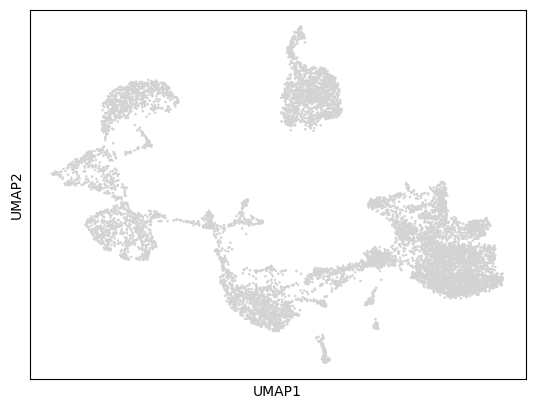

In [13]:
sc.pl.umap(adata)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

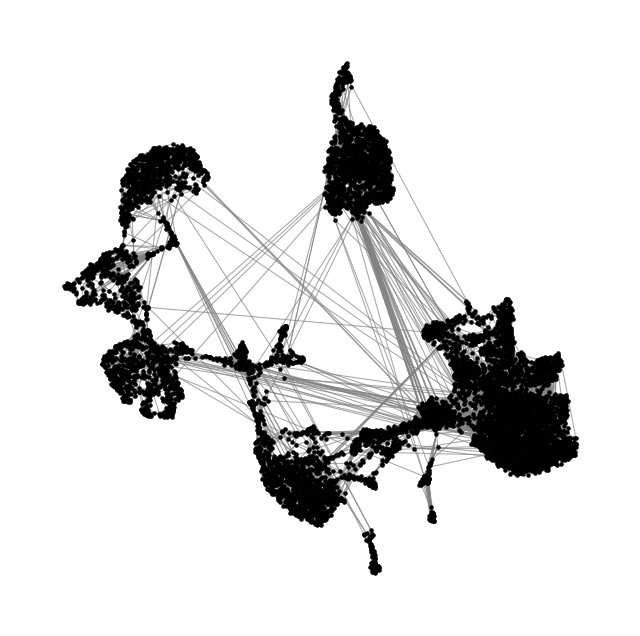

In [14]:
visualize_graph_from_adata(result['graph'], adata)

In [15]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def rowwise_normalize(dat, W):
    """
    Row-normalize a genes x cells matrix, restricted to cells in W (matching column order).
    
    """
    # figure out cell order from W
    if isinstance(W, (np.ndarray, sp.spmatrix)):
        n = W.shape[0]
        cell_names = None
    else:
        raise ValueError("W must be numpy array or scipy sparse matrix.")

    if isinstance(dat, pd.DataFrame):
        # subset columns to match W column names
        if cell_names is None:
            # assume dat already restricted/ordered externally
            X = dat.values
            gene_names = dat.index
            cell_names = dat.columns
        else:
            X = dat.loc[:, cell_names].values
            gene_names = dat.index
    else:
        X = np.asarray(dat)
        gene_names = np.arange(X.shape[0])
        cell_names = np.arange(X.shape[1])

    # row sums
    row_sums = X.sum(axis=1)
    keep = row_sums != 0
    X = X[keep]
    row_sums = row_sums[keep][:, None]

    rho = X / row_sums

    return pd.DataFrame(rho, index=np.array(gene_names)[keep], columns=cell_names)


In [16]:
rho = rowwise_normalize(dat, W)

In [17]:
import numpy as np
from scipy import sparse
from typing import Dict, Union
import warnings

def doubly_stochastic(W: np.ndarray, max_iter: int = 1000, tol: float = 1e-6) -> np.ndarray:
    """
    Convert a symmetric affinity matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    """
    n = W.shape[0]
    P = W.copy()
    
    for _ in range(max_iter):
        # Row normalization
        row_sums = P.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        P = P / row_sums
        
        # Column normalization
        col_sums = P.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1  # Avoid division by zero
        P = P / col_sums
        
        # Check convergence
        if np.allclose(P.sum(axis=1), 1, atol=tol) and np.allclose(P.sum(axis=0), 1, atol=tol):
            break
    
    return P


def rowwise_normalize(W: np.ndarray) -> np.ndarray:
    """
    Row-wise normalization of a matrix (creates a row-stochastic matrix).
    
    """
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return W / row_sums


def construct_diffusion_operators(
    W: Union[np.ndarray, sparse.spmatrix], 
    max_time: int,
) -> Dict[int, sparse.spmatrix]:
    """
    Constructs a list of diffusion operators for a given symmetric affinity matrix of a graph.
    
    """
    
    print("Creating diffusion operators...")
    
    # Convert to dense array if sparse for initial processing
    if sparse.issparse(W):
        W_dense = W.toarray()
    else:
        W_dense = W.copy()
    
    P = doubly_stochastic(W_dense)
    
    n = P.shape[0]
    
    if max_time < 1:
        raise ValueError("Incorrect diffusion time, no propagation (max_time must be >= 1)")
    
    # Initialize list with identity matrix (t=0)
    P_dict = {0: sparse.identity(n, format='csr')}
    
    # Current P matrix
    P_current = P.copy()
    t = 1
    max_steps = int(np.floor(np.log2(max_time)))
    
    # Convergence criterion: check if diagonal approaches 1/n
    convergence_threshold = 1e-2 * n
    
    while t <= max_steps:
        # Check convergence: if diagonal elements approach uniform distribution
        diag_check = np.abs((n * np.diag(P_current)) * n - n)
        max_deviation = np.max(diag_check)
        
        print(f"  Step {t}: max deviation from convergence = {max_deviation:.6f}")
        
        if max_deviation < convergence_threshold:
            print(f"  Converged at step {t} (time = {2**(t-1)})")
            break
        
        # Compute P^(2^t) = P^(2^(t-1)) * P^(2^(t-1))
        P_current = P_current @ P_current
        
        # Store as sparse matrix
        P_dict[2**t] = sparse.csr_matrix(P_current)
        
        t += 1
    
    actual_max_time = 2**(t-1) if t > 1 else 0
    print(f"Max diffusion time: {actual_max_time}")
    print(f"Total operators created: {len(P_dict)}")
    
    return P_dict

In [18]:
start_time = time.time()
P_ls = construct_diffusion_operators(W, max_time=2**3)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Creating diffusion operators...
  Step 1: max deviation from convergence = 44100181.619722
  Step 2: max deviation from convergence = 29041190.920571
  Step 3: max deviation from convergence = 12941092.785833
Max diffusion time: 8
Total operators created: 4
Execution time: 284.46716046333313 seconds


In [19]:
P_ls

{0: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 8713 stored elements in Compressed Sparse Row format>,
 2: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 318685 stored elements in Compressed Sparse Row format>,
 4: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 2983441 stored elements in Compressed Sparse Row format>,
 8: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 19782363 stored elements in Compressed Sparse Row format>}

In [20]:
print(P_ls[4][(0,0)])

0.13124670369592414


In [21]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba

def visualize_diffusion(
    coord,
    rho,
    gene_name,
    P_ls=None,
    W=None,
    check_time=None,
    gene_color="blue",
    construct_diffusion_fn=None,   # pass construct_diffusion_operators if you want auto-build from W
    figsize_per_panel=(4, 4),
    point_size=8,
):
    """
    Visualize diffusion of an initial state over dyadic times.
    """
    # --- inputs to arrays ---
    coord = np.asarray(coord)
    N = coord.shape[0]

    init = np.asarray(rho.loc[gene, adata.obs_names].values)
    # Make it a (1, N) row vector
    if init.ndim == 1:
        init = init[None, :]
    if init.shape[0] != 1 and init.shape[1] == 1:
        init = init.T

    # --- handle times like R: convert to exponents, dedupe, keep >=0, then back to times (2^k), keep 0 if present ---
    if check_time is None or len(check_time) == 0:
        raise ValueError("check_time must be provided, e.g., [0, 2, 2**4, 2**10].")

    check_time = list(check_time)
    include_zero = (0 in check_time)
    # map to log2, unique, >=0
    exps = []
    for t in check_time:
        if t <= 0:
            if t == 0:
                continue
            else:
                continue
        exps.append(int(np.floor(np.log2(t))))
    exps = sorted(set([e for e in exps if e >= 0]))
    times = ([0] if include_zero else []) + [2**e for e in exps]

    # --- ensure P_ls available ---
    if P_ls is None:
        if W is None or construct_diffusion_fn is None:
            raise ValueError("Provide P_ls OR (W and construct_diffusion_fn) to build diffusion operators.")
        max_t = max(times)
        P_ls = construct_diffusion_fn(W=W, max_time=max_t)

    # P_ls may have keys as ints; make a view with int keys
    P_map = {}
    for k, v in P_ls.items():
        try:
            key = int(k)
        except Exception:
            # if keys are strings like "0","2","4", try to parse
            key = int(str(k))
        P_map[key] = v

    # keep only times present
    times = [t for t in times if t in P_map]
    if not times:
        raise ValueError("None of the requested check_time values are present in P_ls.")

    # --- compute multi_state for each time ---
    # multi_state will be (N, len(times)) (we’ll transpose after computing rowwise)
    states = []
    max_vals = []
    for t in times:
        P = P_map[t]
        P = P if sp.issparse(P) else np.asarray(P)
        # init is (1,N); want (N, ) result transposed to (N,)
        state = (init @ P).ravel()
        states.append(state)
        max_vals.append(np.max(state) if state.size else 0.0)

    multi_state = np.column_stack(states)  # shape (N, T)
    # normalize each column to [0,1]
    col_max = np.array(max_vals)
    multi_state_norm = multi_state / col_max

    # --- color map from lightgrey -> gene_color ---
    high_rgba = to_rgba(gene_color)
    cmap = LinearSegmentedColormap.from_list("gene_grad", ["lightgrey", high_rgba])

    # --- plot panels in one row ---
    n_panels = len(times)
    fig_w = figsize_per_panel[0] * n_panels
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n_panels, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    # helper to build title like R: T=0 or T=2^{k}
    def _panel_title(t):
        if t == 0:
            return r"$T = 0$"
        k = int(np.log2(t))
        return rf"$T = 2^{{{k}}}$"

    for j, ax in enumerate(axes):
        vals = multi_state_norm[:, j]
        # order points so high values on top
        order = np.argsort(vals)
        x = coord[order, 0]
        y = coord[order, 1]
        c = vals[order]
        
        sc = ax.scatter(x, y, c=c, s=point_size, cmap=cmap, vmin=0.0, vmax=1.0, linewidths=0)
        ax.set_title(_panel_title(times[j]), fontsize=14, fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_frame_on(False)
        
        cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cb.set_label("Density", fontsize=10)
        cb.set_ticks([0.0, 1.0])

    if gene_name:
        fig.suptitle(gene_name, fontsize=18, fontweight="bold", y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig, axes

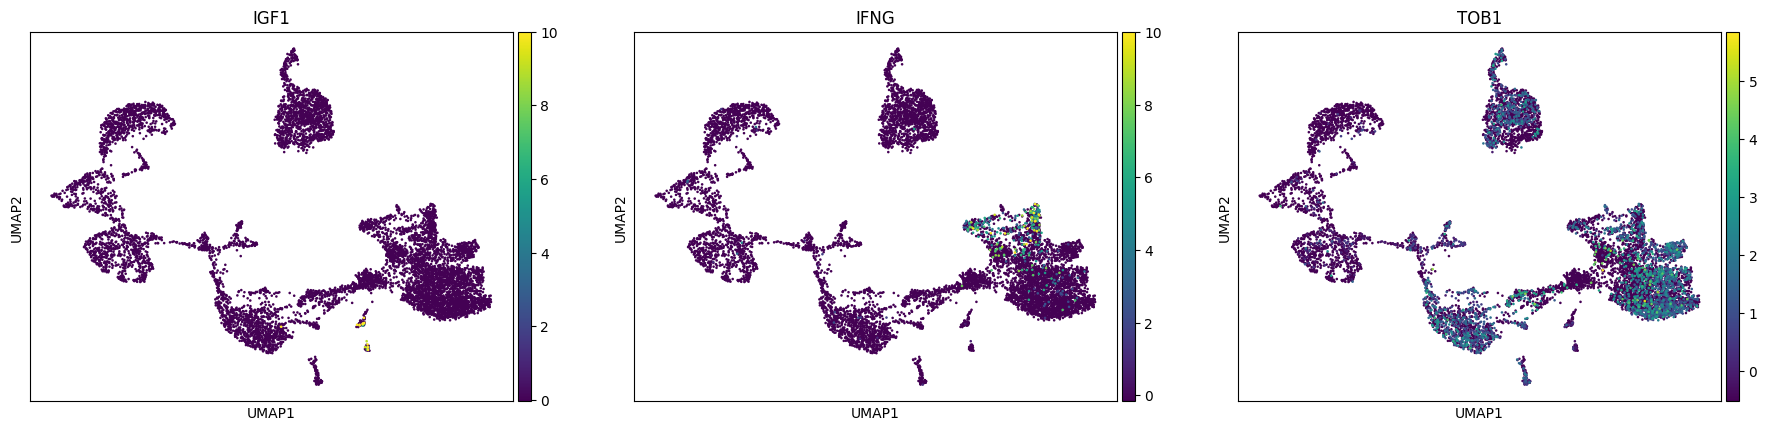

In [22]:
sc.pl.umap(adata, color = ['IGF1','IFNG','TOB1'])

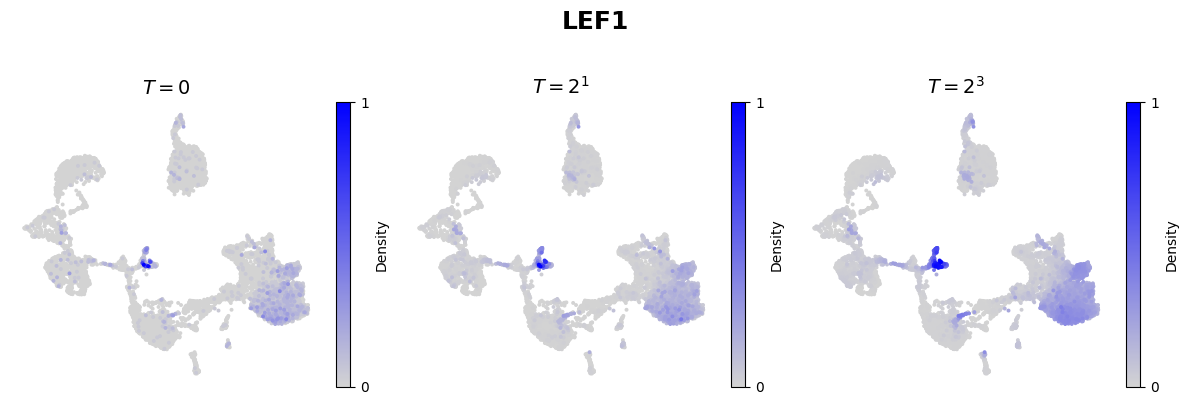

In [23]:
gene = 'LEF1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    check_time=[0, 2, 2**3],
    gene_name=gene,
    gene_color="blue"
)

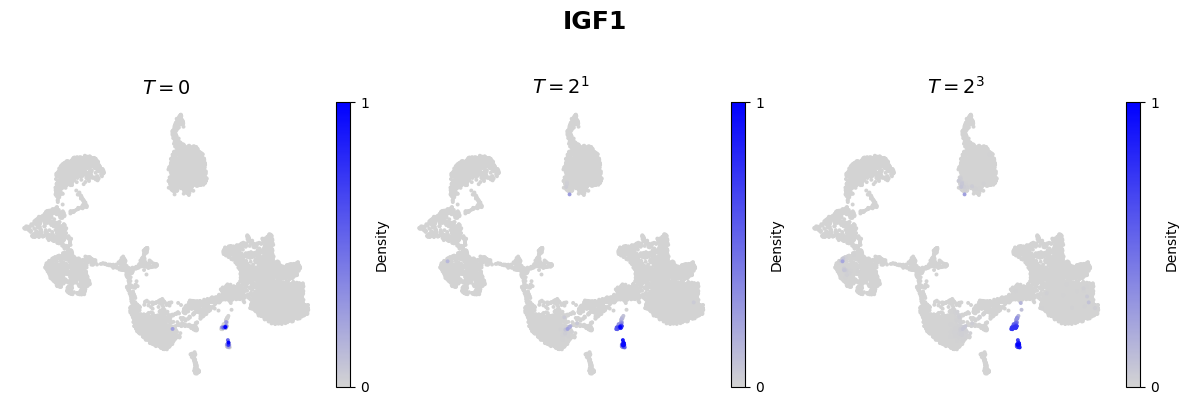

In [24]:
gene = 'IGF1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    check_time=[0, 2, 2**3],
    gene_name=gene,
    gene_color="blue"
)

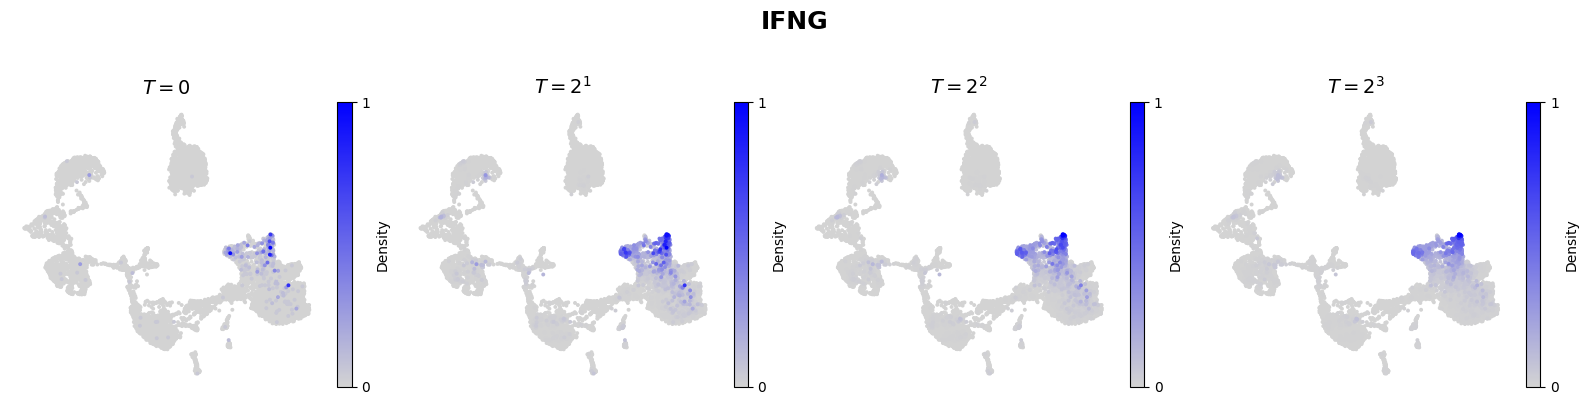

In [25]:
gene = 'IFNG'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    check_time=[0, 2, 2**2, 2**3],
    gene_name=gene,
    gene_color="blue"
)

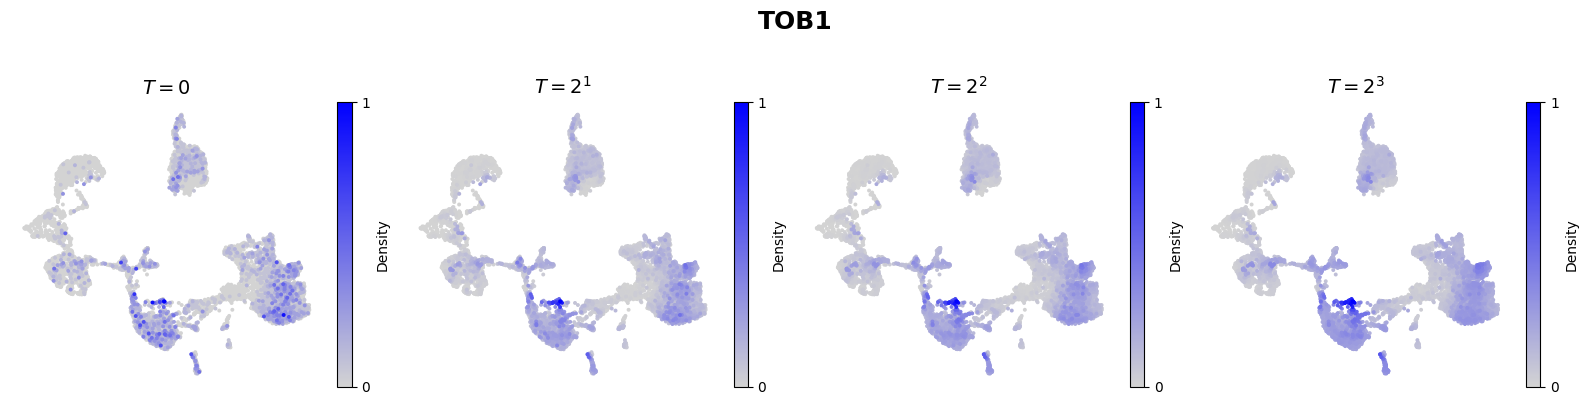

In [26]:
gene = 'TOB1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    check_time=[0, 2, 2**2, 2**3],
    gene_name=gene,
    gene_color="blue"
)

In [27]:
P_ls

{0: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 8713 stored elements in Compressed Sparse Row format>,
 2: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 318685 stored elements in Compressed Sparse Row format>,
 4: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 2983441 stored elements in Compressed Sparse Row format>,
 8: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 19782363 stored elements in Compressed Sparse Row format>}

In [62]:
from __future__ import annotations
from collections import OrderedDict
from typing import Iterable, Dict, Tuple, Union
import numpy as np
import pandas as pd
import scipy.sparse as sp


# ---------- helpers ----------
def _as_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

def fast_matmul(A, B):
    if sp.issparse(A) and sp.issparse(B):
        return (A @ B).toarray()  # genes x cells, dense result
    elif sp.issparse(A):
        return (A @ B)  # dense or sparse B → dense np.ndarray if B dense
    elif sp.issparse(B):
        return A @ B     # returns np.ndarray
    else:
        return A @ B

def _rowwise_kl(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    KL divergence per row: KL(p || q) = sum_i p_i * log(p_i / q_i)
    Assumes rows sum to ~1. Adds eps for numerical stability.
    Returns 1D array of length n_rows.
    """
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)), axis=1)

def _rowwise_entropy(p: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Shannon entropy per row: H(p) = -sum_i p_i log p_i."""
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def get_score_profile(
    state_0: np.ndarray,        # genes x cells (row-stochastic)
    state_inf: np.ndarray,      # (cells,) stationary distribution
    state_t: np.ndarray,
    score_ls: Iterable[str] = ("score0",),
) -> pd.DataFrame:
    """
    Compute requested score columns. Supported keys:
      - 'score0'   : KL(state_t || state_inf)
      - 'entropy'  : entropy(state_0)
      - 'max_score0': KL(state_0 || state_inf)  (used as normalizer baseline)
    Returns DataFrame with rows = genes, cols = requested metrics.
    """
    # ensure arrays
    S0 = np.asarray(state_0)
    ST = np.asarray(state_t)
    pi = np.asarray(state_inf).ravel()
    if S0.ndim != 2 or ST.ndim != 2:
        raise ValueError("state_0 and state_t must be 2D (genes x cells).")
    if S0.shape != ST.shape:
        raise ValueError("state_0 and state_t must have the same shape.")
    if ST.shape[1] != pi.shape[0]:
        raise ValueError("state_inf length must equal #cells.")

    n_genes = S0.shape[0]
    out = {}

    # broadcast pi to row shape when needed
    pi_row = np.broadcast_to(pi, S0.shape)

    if "score0" in score_ls:
        out["score0"] = _rowwise_kl(ST, pi_row)

    if "entropy" in score_ls:
        out["entropy"] = _rowwise_entropy(S0)

    if "max_score0" in score_ls:
        # baseline KL at t = 0
        pi0_row = np.broadcast_to(pi, S0.shape)
        out["max_score0"] = _rowwise_kl(S0, pi0_row)

    return pd.DataFrame(out, index=np.arange(n_genes))

def gpu_get_score_profile(
    state_0: np.ndarray,        # genes x cells (row-stochastic)
    state_inf: np.ndarray,      # (cells,) stationary distribution
    state_t: cp.ndarray,
    score_ls: Iterable[str] = ("score0",),
) -> pd.DataFrame:
    """
    Compute requested score columns. Supported keys:
      - 'score0'   : KL(state_t || state_inf)
      - 'entropy'  : entropy(state_0)
      - 'max_score0': KL(state_0 || state_inf)  (used as normalizer baseline)
    Returns DataFrame with rows = genes, cols = requested metrics.
    """
    # ensure arrays
    S0 = np.asarray(state_0)
    ST = cp.asnumpy(state_t)
    pi = np.asarray(state_inf).ravel()
    if S0.ndim != 2 or ST.ndim != 2:
        raise ValueError("state_0 and state_t must be 2D (genes x cells).")
    if S0.shape != ST.shape:
        raise ValueError("state_0 and state_t must have the same shape.")
    if ST.shape[1] != pi.shape[0]:
        raise ValueError("state_inf length must equal #cells.")

    n_genes = S0.shape[0]
    out = {}

    # broadcast pi to row shape when needed
    pi_row = np.broadcast_to(pi, S0.shape)

    if "score0" in score_ls:
        out["score0"] = _rowwise_kl(ST, pi_row)

    if "entropy" in score_ls:
        out["entropy"] = _rowwise_entropy(S0)

    if "max_score0" in score_ls:
        # baseline KL at t = 0
        pi0_row = np.broadcast_to(pi, S0.shape)
        out["max_score0"] = _rowwise_kl(S0, pi0_row)

    return pd.DataFrame(out, index=np.arange(n_genes))


# ---------- main function ----------
def fast_calculate_score_profile(
    W,
    init_state,
    score_ls,
    P_ls
) -> pd.DataFrame:
    
    Wn = W.shape[0]

    gene_names = init_state.index.copy()
    X = init_state.values
    
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check the dimension! init_state must have #cells equal to W.shape[0].")

    final_state = np.full(Wn, 1.0 / Wn, dtype=float)

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for P in P_ls:
        if P_ls[P].nnz < 1000000:
            df_t = get_score_profile(
                state_0=X,
                state_t=(X @ P_ls[P]),
                state_inf=final_state,
                score_ls=score_ls,
            )
        else:
            df_t = gpu_get_score_profile(
                state_0=X,
                state_t=(cp.asarray(X) @ cp.asarray(_as_dense(P_ls[P]))),
                state_inf=final_state,
                score_ls=score_ls,
            )

        df_t.columns = [f"{col}_{P}" for col in df_t.columns]
        per_time_frames.append(df_t)

    score_df = pd.concat(per_time_frames, axis=1)
    
    score_df.index = gene_names

    return score_df

In [55]:
X = rho.values

In [56]:
start_time = time.time()
print(X @ P_ls[0])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00092166 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Execution time: 3.5130462646484375 seconds


In [53]:
for P in P_ls:
    print(P_ls[P].nnz)

8713
318685
2983441
19782363


In [33]:
start_time = time.time()
print(X @ P_ls[2])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.53433572e-05 2.26872706e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.77842656e-06 1.14404847e-04 0.00000000e+00 ... 3.45308968e-05
  2.22116572e-04 0.00000000e+00]
 ...
 [2.65786627e-05 4.64353662e-04 0.00000000e+00 ... 2.52024082e-05
  6.94692667e-05 2.37816209e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.09407079e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Execution time: 5.4480204582214355 seconds


In [34]:
start_time = time.time()
print(X @ P_ls[4])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[6.22037723e-06 0.00000000e+00 2.01955250e-05 ... 2.56898866e-05
  0.00000000e+00 0.00000000e+00]
 [1.87243461e-05 2.50489383e-04 5.95869058e-08 ... 0.00000000e+00
  5.98373648e-05 0.00000000e+00]
 [2.80379037e-05 1.45427139e-04 3.30978591e-05 ... 8.14442521e-05
  1.78694789e-04 3.33873966e-05]
 ...
 [5.51794288e-05 4.01021162e-04 1.88938850e-06 ... 2.98215426e-05
  1.02999964e-04 2.64686800e-04]
 [0.00000000e+00 7.05041646e-06 3.62700969e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.98258319e-05 3.93619484e-04 4.28524106e-05 ... 0.00000000e+00
  6.32161345e-05 8.19841552e-05]]
Execution time: 31.25830054283142 seconds


In [35]:
start_time = time.time()
print(X @ P_ls[8])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[1.69582502e-05 3.49896092e-05 8.15307117e-05 ... 6.69685000e-05
  1.11168796e-05 1.49215325e-08]
 [1.53428263e-05 3.52394556e-04 1.49374467e-06 ... 2.74219090e-06
  5.45715977e-05 1.31864630e-07]
 [6.64452893e-05 2.00630936e-04 6.52734511e-05 ... 1.10863646e-04
  1.28470171e-04 8.77770816e-05]
 ...
 [8.56158933e-05 3.59130778e-04 7.17920209e-06 ... 3.33797881e-05
  1.17001093e-04 2.58589257e-04]
 [4.94141288e-09 3.32542305e-05 1.34643371e-04 ... 2.64875470e-08
  5.38775042e-06 1.09655282e-05]
 [6.93789328e-05 4.48916684e-04 6.46133949e-05 ... 1.70476895e-07
  1.29870027e-04 1.13486403e-04]]
Execution time: 195.06957173347473 seconds


In [38]:
start_time = time.time()
score_df = fast_calculate_score_profile(
    W = W,
    init_state = rho,
    score_ls = ("score0",),
    P_ls = P_ls
)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 258.0431785583496 seconds


In [63]:
start_time = time.time()
score_df = fast_calculate_score_profile(
    W = W,
    init_state = rho,
    score_ls = ("score0",),
    P_ls = P_ls
)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU Accelerated Execution time: {execution_time} seconds")

GPU Accelerated Execution time: 69.57357954978943 seconds


In [64]:
score_df

,score0_0,score0_2,score0_4,score0_8
AL627309.1,5.853695,2.784990,1.728825,1.010099
AL627309.5,4.526444,1.960549,1.446462,1.135534
LINC01409,3.031838,0.921578,0.593165,0.414420
LINC01128,2.359094,0.974700,0.815201,0.726628
LINC00115,4.192634,1.518362,0.840365,0.455828
...,...,...,...,...
AL592183.1,2.787112,0.884099,0.632787,0.484475
AC240274.1,4.810535,2.081121,1.281090,0.772239
AC004556.3,2.458462,1.061542,0.885964,0.754292
AC233755.1,6.014227,3.569465,3.080859,2.699907


In [39]:
import cupy as cp

In [43]:
cp.asarray(_as_dense(P_ls[0]))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [44]:
time_step = 0

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00092166 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
CPU time: 3.165225028991699 seconds


/home/jasson/anaconda3/lib/python3.9/site-packages/cupy/_creation/from_data.py:88: PerformanceWarning: Using synchronous transfer as pinned memory (607330952 bytes) could not be allocated. This generally occurs because of insufficient host memory. The original error was: cudaErrorMemoryAllocation: out of memory
  return _core.array(a, dtype, False, order, blocking=blocking)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00092166 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
GPU time: 23.277716159820557 seconds


In [46]:
time_step = 2

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.53433572e-05 2.26872706e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.77842656e-06 1.14404847e-04 0.00000000e+00 ... 3.45308968e-05
  2.22116572e-04 0.00000000e+00]
 ...
 [2.65786627e-05 4.64353662e-04 0.00000000e+00 ... 2.52024082e-05
  6.94692667e-05 2.37816209e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.09407079e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
CPU time: 7.031465530395508 seconds
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.53433572e-05 2.26872706e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.77842656e-06 1.14404847e-04 0.00000000e+00 ... 3.45308968e-05
  2.22116572e-04 0.00000000e+00]
 ...
 [2.65786627e-05 4.64353662e-04 0.00000000e+00 ... 2.52024082e

In [61]:
type(cp_rho)

cupy.ndarray

In [47]:
time_step = 4

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

[[6.22037723e-06 0.00000000e+00 2.01955250e-05 ... 2.56898866e-05
  0.00000000e+00 0.00000000e+00]
 [1.87243461e-05 2.50489383e-04 5.95869058e-08 ... 0.00000000e+00
  5.98373648e-05 0.00000000e+00]
 [2.80379037e-05 1.45427139e-04 3.30978591e-05 ... 8.14442521e-05
  1.78694789e-04 3.33873966e-05]
 ...
 [5.51794288e-05 4.01021162e-04 1.88938850e-06 ... 2.98215426e-05
  1.02999964e-04 2.64686800e-04]
 [0.00000000e+00 7.05041646e-06 3.62700969e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.98258319e-05 3.93619484e-04 4.28524106e-05 ... 0.00000000e+00
  6.32161345e-05 8.19841552e-05]]
CPU time: 33.34963822364807 seconds
[[6.22037723e-06 0.00000000e+00 2.01955250e-05 ... 2.56898866e-05
  0.00000000e+00 0.00000000e+00]
 [1.87243461e-05 2.50489383e-04 5.95869058e-08 ... 0.00000000e+00
  5.98373648e-05 0.00000000e+00]
 [2.80379037e-05 1.45427139e-04 3.30978591e-05 ... 8.14442521e-05
  1.78694789e-04 3.33873966e-05]
 ...
 [5.51794288e-05 4.01021162e-04 1.88938850e-06 ... 2.98215426e

In [45]:
time_step = 8

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

[[1.69582502e-05 3.49896092e-05 8.15307117e-05 ... 6.69685000e-05
  1.11168796e-05 1.49215325e-08]
 [1.53428263e-05 3.52394556e-04 1.49374467e-06 ... 2.74219090e-06
  5.45715977e-05 1.31864630e-07]
 [6.64452893e-05 2.00630936e-04 6.52734511e-05 ... 1.10863646e-04
  1.28470171e-04 8.77770816e-05]
 ...
 [8.56158933e-05 3.59130778e-04 7.17920209e-06 ... 3.33797881e-05
  1.17001093e-04 2.58589257e-04]
 [4.94141288e-09 3.32542305e-05 1.34643371e-04 ... 2.64875470e-08
  5.38775042e-06 1.09655282e-05]
 [6.93789328e-05 4.48916684e-04 6.46133949e-05 ... 1.70476895e-07
  1.29870027e-04 1.13486403e-04]]
CPU time: 207.73195719718933 seconds
[[1.69582502e-05 3.49896092e-05 8.15307117e-05 ... 6.69685000e-05
  1.11168796e-05 1.49215325e-08]
 [1.53428263e-05 3.52394556e-04 1.49374467e-06 ... 2.74219090e-06
  5.45715977e-05 1.31864630e-07]
 [6.64452893e-05 2.00630936e-04 6.52734511e-05 ... 1.10863646e-04
  1.28470171e-04 8.77770816e-05]
 ...
 [8.56158933e-05 3.59130778e-04 7.17920209e-06 ... 3.33797881

In [ ]:
print(P_ls[8])

In [ ]:
score_df

In [ ]:
rho

In [ ]:
P_ls[0]

In [ ]:
    Wn = W.shape[0]

In [ ]:
    gene_names = rho.index.copy()
    X = rho.values

In [ ]:
Wn

In [ ]:
final_state = np.full(Wn, 1.0 / Wn, dtype=float)
final_state

In [ ]:
    parsed_items: list[Tuple[int, Union[np.ndarray, sp.spmatrix]]] = []

    for k, v in P_ls.items():
        t = int(k)
        parsed_items.append((t, v))
        
    parsed_items.sort(key=lambda kv: kv[0])

In [ ]:
parsed_items[0][0]

In [ ]:
state_t = fast_matmul(X, parsed_items[0][1])

In [ ]:
state_t

In [ ]:
P_ls

In [ ]:
_as_dense(fast_matmul(X, P_ls[0]))

In [ ]:
def _as_dense(a):
    if sp.issparse(a):
        print('converted!')
        return a.toarray() 
    else:
        return np.asarray(a)

In [ ]:
_as_dense(P_ls[0])

In [ ]:
print(P_ls[4])

In [ ]:
from __future__ import annotations
from collections import OrderedDict
from typing import Iterable, Dict, Tuple, Union
import numpy as np
import pandas as pd
import scipy.sparse as sp


# ---------- helpers ----------
def _as_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

def fast_matmul(A, B):
    """Row-wise states (genes x cells) times (cells x cells) diffusion operator."""
    if sp.issparse(A) and sp.issparse(B):
        return (A @ B).toarray()  # genes x cells, dense result
    elif sp.issparse(A):
        return (A @ B)  # dense or sparse B → dense np.ndarray if B dense
    elif sp.issparse(B):
        return A @ B     # returns np.ndarray
    else:
        return A @ B

def _rowwise_kl(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    KL divergence per row: KL(p || q) = sum_i p_i * log(p_i / q_i)
    Assumes rows sum to ~1. Adds eps for numerical stability.
    Returns 1D array of length n_rows.
    """
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)), axis=1)

def _rowwise_entropy(p: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Shannon entropy per row: H(p) = -sum_i p_i log p_i."""
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def get_score_profile(
    state_0: np.ndarray,        # genes x cells (row-stochastic)
    state_t: np.ndarray,        # genes x cells (row-stochastic)
    state_inf: np.ndarray,      # (cells,) stationary distribution
    score_ls: Iterable[str] = ("score0",),
) -> pd.DataFrame:
    """
    Compute requested score columns. Supported keys:
      - 'score0'   : KL(state_t || state_inf)
      - 'entropy'  : entropy(state_0)
      - 'max_score0': KL(state_0 || state_inf)  (used as normalizer baseline)
    Returns DataFrame with rows = genes, cols = requested metrics.
    """
    # ensure arrays
    S0 = np.asarray(state_0)
    ST = np.asarray(state_t)
    pi = np.asarray(state_inf).ravel()
    if S0.ndim != 2 or ST.ndim != 2:
        raise ValueError("state_0 and state_t must be 2D (genes x cells).")
    if S0.shape != ST.shape:
        raise ValueError("state_0 and state_t must have the same shape.")
    if ST.shape[1] != pi.shape[0]:
        raise ValueError("state_inf length must equal #cells.")

    n_genes = S0.shape[0]
    out = {}

    # broadcast pi to row shape when needed
    pi_row = np.broadcast_to(pi, ST.shape)

    if "score0" in score_ls:
        out["score0"] = _rowwise_kl(ST, pi_row)

    if "entropy" in score_ls:
        out["entropy"] = _rowwise_entropy(S0)

    if "max_score0" in score_ls:
        # baseline KL at t = 0
        pi0_row = np.broadcast_to(pi, S0.shape)
        out["max_score0"] = _rowwise_kl(S0, pi0_row)

    return pd.DataFrame(out, index=np.arange(n_genes))


# ---------- main function ----------
def fast_calculate_score_profile(
    W,
    init_state,
    score_ls,
    construct_diffusion_operators_fn,  # pass construct_diffusion_operators if P_ls is None
    P_ls,
    max_time: int = 2**15,
) -> pd.DataFrame:
    """
    Python port of:
      fast_calculate_score_profile(W, max_time, init_state, P_ls=NULL, score_ls=c('score0'))

    Parameters
    ----------
    W : (N x N) affinity / graph matrix (doubly-stochastic target)
    max_time : int
        Maximum diffusion time passed to the diffusion operator builder if P_ls is None.
    init_state : genes x cells matrix (row-stochastic; rows sum ~1). If shape is (cells x genes)
        it will be transposed to (genes x cells).
    P_ls : OrderedDict[int, (np.ndarray|scipy.sparse)], optional
        Diffusion operators keyed by time (e.g., {0: I, 2: P^2, 4: P^4, ...}).
        If None, you must provide construct_diffusion_operators_fn to build them from W.
    score_ls : iterable of str
        Which scores to compute at each time (default: ('score0',)).
    construct_diffusion_operators_fn : callable, optional
        Function like construct_diffusion_operators(W, max_time).

    Returns
    -------
    pd.DataFrame
        Rows = genes, columns = per-time score columns + ('entropy','max_score0') baselines.
        Per-time columns are named like '<score_name>_<time>'.
    """
    # ----- align shapes like in R -----
    Wn = W.shape[0]
    # convert init_state to ndarray, keep gene names if provided
    if isinstance(init_state, pd.DataFrame):
        gene_names = init_state.index.copy()
        X = init_state.values
    else:
        gene_names = None
        X = np.asarray(init_state)

    # if (ncol(W) != ncol(init_state)) & (ncol(W) == nrow(init_state)) -> transpose
    # In Python terms: if W.shape[1] != X.shape[1] and W.shape[1] == X.shape[0]
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check the dimension! init_state must have #cells equal to W.shape[0].")

    # ----- final_state for bi-stochastic (uniform) -----
    final_state = np.full(Wn, 1.0 / Wn, dtype=float)

    # ----- build diffusion operators if needed -----
    if P_ls is None:
        if construct_diffusion_operators_fn is None:
            raise ValueError("P_ls is None; provide construct_diffusion_operators_fn to build from W.")
        P_ls = construct_diffusion_operators_fn(W=W, max_time=max_time)

    # normalize/ensure ordered keys (as R iterates in list order)
    # Keep only integer-like keys; sort ascending by time.
    parsed_items: list[Tuple[int, Union[np.ndarray, sp.spmatrix]]] = []
    for k, v in P_ls.items():
        try:
            t = int(k)
        except Exception:
            t = int(str(k))
        parsed_items.append((t, v))
    parsed_items.sort(key=lambda kv: kv[0])

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for t, P in parsed_items:
        Pm = P  # can be sparse or dense
        # state = init_state %*% P
        state_t = fast_matmul(X, Pm)
        state_t = _as_dense(state_t)  # ensure ndarray
        # scores for this time
        df_t = get_score_profile(
            state_0=X,
            state_t=state_t,
            state_inf=final_state,
            score_ls=score_ls,
        )
        # rename columns to include time suffix
        df_t.columns = [f"{col}_{t}" for col in df_t.columns]
        per_time_frames.append(df_t)

    # column-bind all times
    score_df = pd.concat(per_time_frames, axis=1)

    # ----- add entropy and max_score0 at t=0 (like R) -----
    df_base = get_score_profile(
        state_0=X,
        state_t=X,  # not used by 'entropy'/'max_score0' but mirrors R call
        state_inf=final_state,
        score_ls=("entropy", "max_score0"),
    )
    score_df = pd.concat([score_df, df_base], axis=1)

    # gene row names
    if gene_names is None:
        gene_names = [f"gene_{i}" for i in range(score_df.shape[0])]
    score_df.index = gene_names

    # data.frame in R → DataFrame here
    return score_df

In [ ]:
score_df = fast_calculate_score_profile(
    W=W,
    init_state=rho,         # genes x cells
    P_ls=P_ls,
    score_ls=("score0",),
    construct_diffusion_operators_fn=None, # add more if you extend get_score_profile
    max_time=2**4
)

In [ ]:
score_df

In [ ]:
from __future__ import annotations
from collections import OrderedDict
from typing import Iterable, Dict, Tuple, Union
import numpy as np
import pandas as pd
import scipy.sparse as sp


# ---------- helpers ----------
def _as_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

def fast_matmul(A, B):
    """Row-wise states (genes x cells) times (cells x cells) diffusion operator."""
    if sp.issparse(A) and sp.issparse(B):
        return (A @ B).toarray()  # genes x cells, dense result
    elif sp.issparse(A):
        return (A @ B)  # dense or sparse B → dense np.ndarray if B dense
    elif sp.issparse(B):
        return A @ B     # returns np.ndarray
    else:
        return A @ B

def _rowwise_kl(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    KL divergence per row: KL(p || q) = sum_i p_i * log(p_i / q_i)
    Assumes rows sum to ~1. Adds eps for numerical stability.
    Returns 1D array of length n_rows.
    """
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)), axis=1)

def _rowwise_entropy(p: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Shannon entropy per row: H(p) = -sum_i p_i log p_i."""
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def get_score_profile(
    state_0: np.ndarray,        # genes x cells (row-stochastic)
    state_t: np.ndarray,        # genes x cells (row-stochastic)
    state_inf: np.ndarray,      # (cells,) stationary distribution
    score_ls: Iterable[str] = ("score0",),
) -> pd.DataFrame:
    """
    Compute requested score columns. Supported keys:
      - 'score0'   : KL(state_t || state_inf)
      - 'entropy'  : entropy(state_0)
      - 'max_score0': KL(state_0 || state_inf)  (used as normalizer baseline)
    Returns DataFrame with rows = genes, cols = requested metrics.
    """
    # ensure arrays
    S0 = np.asarray(state_0)
    ST = np.asarray(state_t)
    pi = np.asarray(state_inf).ravel()
    if S0.ndim != 2 or ST.ndim != 2:
        raise ValueError("state_0 and state_t must be 2D (genes x cells).")
    if S0.shape != ST.shape:
        raise ValueError("state_0 and state_t must have the same shape.")
    if ST.shape[1] != pi.shape[0]:
        raise ValueError("state_inf length must equal #cells.")

    n_genes = S0.shape[0]
    out = {}

    # broadcast pi to row shape when needed
    pi_row = np.broadcast_to(pi, ST.shape)

    if "score0" in score_ls:
        out["score0"] = _rowwise_kl(ST, pi_row)

    if "entropy" in score_ls:
        out["entropy"] = _rowwise_entropy(S0)

    if "max_score0" in score_ls:
        # baseline KL at t = 0
        pi0_row = np.broadcast_to(pi, S0.shape)
        out["max_score0"] = _rowwise_kl(S0, pi0_row)

    return pd.DataFrame(out, index=np.arange(n_genes))


# ---------- main function ----------
def fast_calculate_score_profile(
    W,
    init_state,
    score_ls,
    construct_diffusion_operators_fn,  # pass construct_diffusion_operators if P_ls is None
    P_ls,
    max_time: int = 2**15,
) -> pd.DataFrame:
    """
    Python port of:
      fast_calculate_score_profile(W, max_time, init_state, P_ls=NULL, score_ls=c('score0'))

    Parameters
    ----------
    W : (N x N) affinity / graph matrix (doubly-stochastic target)
    max_time : int
        Maximum diffusion time passed to the diffusion operator builder if P_ls is None.
    init_state : genes x cells matrix (row-stochastic; rows sum ~1). If shape is (cells x genes)
        it will be transposed to (genes x cells).
    P_ls : OrderedDict[int, (np.ndarray|scipy.sparse)], optional
        Diffusion operators keyed by time (e.g., {0: I, 2: P^2, 4: P^4, ...}).
        If None, you must provide construct_diffusion_operators_fn to build them from W.
    score_ls : iterable of str
        Which scores to compute at each time (default: ('score0',)).
    construct_diffusion_operators_fn : callable, optional
        Function like construct_diffusion_operators(W, max_time).

    Returns
    -------
    pd.DataFrame
        Rows = genes, columns = per-time score columns + ('entropy','max_score0') baselines.
        Per-time columns are named like '<score_name>_<time>'.
    """
    # ----- align shapes like in R -----
    Wn = W.shape[0]
    # convert init_state to ndarray, keep gene names if provided
    if isinstance(init_state, pd.DataFrame):
        gene_names = init_state.index.copy()
        X = init_state.values
    else:
        gene_names = None
        X = np.asarray(init_state)

    # if (ncol(W) != ncol(init_state)) & (ncol(W) == nrow(init_state)) -> transpose
    # In Python terms: if W.shape[1] != X.shape[1] and W.shape[1] == X.shape[0]
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check the dimension! init_state must have #cells equal to W.shape[0].")

    # ----- final_state for bi-stochastic (uniform) -----
    final_state = np.full(Wn, 1.0 / Wn, dtype=float)

    # ----- build diffusion operators if needed -----
    if P_ls is None:
        if construct_diffusion_operators_fn is None:
            raise ValueError("P_ls is None; provide construct_diffusion_operators_fn to build from W.")
        P_ls = construct_diffusion_operators_fn(W=W, max_time=max_time)

    # normalize/ensure ordered keys (as R iterates in list order)
    # Keep only integer-like keys; sort ascending by time.
    parsed_items: list[Tuple[int, Union[np.ndarray, sp.spmatrix]]] = []
    for k, v in P_ls.items():
        try:
            t = int(k)
        except Exception:
            t = int(str(k))
        parsed_items.append((t, v))
    parsed_items.sort(key=lambda kv: kv[0])

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for t, P in parsed_items:
        Pm = P  # can be sparse or dense
        # state = init_state %*% P
        state_t = fast_matmul(X, Pm)
        state_t = _as_dense(state_t)  # ensure ndarray
        # scores for this time
        df_t = get_score_profile(
            state_0=X,
            state_t=state_t,
            state_inf=final_state,
            score_ls=score_ls,
        )
        # rename columns to include time suffix
        df_t.columns = [f"{col}_{t}" for col in df_t.columns]
        per_time_frames.append(df_t)

    # column-bind all times
    score_df = pd.concat(per_time_frames, axis=1)

    # ----- add entropy and max_score0 at t=0 (like R) -----
    df_base = get_score_profile(
        state_0=X,
        state_t=X,  # not used by 'entropy'/'max_score0' but mirrors R call
        state_inf=final_state,
        score_ls=("entropy", "max_score0"),
    )
    score_df = pd.concat([score_df, df_base], axis=1)

    # gene row names
    if gene_names is None:
        gene_names = [f"gene_{i}" for i in range(score_df.shape[0])]
    score_df.index = gene_names

    # data.frame in R → DataFrame here
    return score_df

In [ ]:
score_df = fast_calculate_score_profile(
    W=W,
    init_state=rho,         # genes x cells
    P_ls=P_ls,
    score_ls=("score0",),
    construct_diffusion_operators_fn=None, # add more if you extend get_score_profile
    max_time=2**3
)

In [ ]:
score_df

In [ ]:
X

In [ ]:
import cupy as cp

In [ ]:
time_step = 0

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(P_ls[time_step])
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
time_step = 8

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(P_ls[time_step])
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
P_ls

In [ ]:
stop

In [ ]:
X.dot(P_ls[256])

In [ ]:
stop

In [ ]:
start_time = time.time()
X @ P_ls[256]
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
start_time = time.time()
P = P_ls[256].toarray()
X @ P
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
_as_dense(P_ls[256])

In [ ]:
P_ls[256]

In [ ]:
stop

In [ ]:
_as_dense(fast_matmul(X, P_ls[1048576]))

In [ ]:
def fast_matmul(A, B):
    if sp.issparse(A) and sp.issparse(B):
        return (A @ B).toarray()  # genes x cells, dense result
    elif sp.issparse(A):
        return (A @ B)  # dense or sparse B → dense np.ndarray if B dense
    elif sp.issparse(B):
        return A @ B     # returns np.ndarray
    else:
        return A @ B

In [ ]:
_as_dense(fast_matmul(X, P_ls[8]))

In [ ]:
for t, P in parsed_items:
    _as_dense(fast_matmul(X, P))

In [ ]:
stop

In [ ]:
per_time_frames = []
for t, P in parsed_items:
    # scores for this time
    df_t = get_score_profile(
        state_0=X,
        state_t = _as_dense(fast_matmul(X, P)),
        state_inf=final_state,
        score_ls=("max_score0"),
    )

    df_t.columns = [f"{col}_{t}" for col in df_t.columns]
    per_time_frames.append(df_t)

score_df = pd.concat(per_time_frames, axis=1)

In [ ]:
score_df

In [ ]:
    Wn = W.shape[0]

    gene_names = init_state.index.copy()
    X = init_state.values
    
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check the dimension! init_state must have #cells equal to W.shape[0].")

    final_state = np.full(Wn, 1.0 / Wn, dtype=float)

    # Keep only integer-like keys; sort ascending by time.
    parsed_items: list[Tuple[int, Union[np.ndarray, sp.spmatrix]]] = []
    
    for k, v in P_ls.items():
        t = int(k)
        parsed_items.append((t, v))
        
    parsed_items.sort(key=lambda kv: kv[0])

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for t, P in parsed_items:
        Pm = P 
        # state = init_state %*% P
        state_t = fast_matmul(X, Pm)
        state_t = _as_dense(state_t)
        # scores for this time
        df_t = get_score_profile(
            state_0=X,
            state_inf=final_state,
            score_ls=score_ls,
        )

        df_t.columns = [f"{col}_{t}" for col in df_t.columns]
        per_time_frames.append(df_t)

    score_df = pd.concat(per_time_frames, axis=1)

    df_base = get_score_profile(
        state_0=X,
        state_inf=final_state,
        score_ls=("entropy", "max_score0"),
    )
    score_df = pd.concat([score_df, df_base], axis=1)
    
    score_df.index = gene_names

In [ ]:
score_df = fast_calculate_score_profile(
    W=W,
    init_state=rho,         # genes x cells
    P_ls=P_ls,
    score_ls=("score0",)
)

In [ ]:
score_df

In [ ]:
import numpy as np
import pandas as pd

def obtain_lmds(score_profile: pd.DataFrame) -> pd.Series:
    """
    Compute LMDS (cumulative normalized diffusion KL score).
    """

    cols = score_profile.columns.astype(str)
    score0_cols = [c for c in cols if c.startswith("score0")]
    
    denom = score_profile["max_score0"].replace(0, np.nan)
    df_norm = score_profile.div(denom, axis=0)
    cumulative_score = df_norm[score0_cols].sum(axis=1)

    # Replace NaNs (from 0 denominators) with 0 to mimic R's permissive behavior
    cumulative_score = cumulative_score.fillna(0.0)
    cumulative_score.name = "LMDS"
    
    return cumulative_score

In [ ]:
score_profile = obtain_lmds(score_df)

In [ ]:
score_profile

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_score_pattern(
    score_profile: pd.DataFrame,
    genes=None,
    label_class=None,
    facet_class=None,
    add_point=None, 
    dyadic: bool = True,
    text: bool = False,
    normalize: bool = False,
    figsize=(10, 4),
):
    if genes is None:
        raise ValueError("`genes` must be provided.")

    # Validate genes
    score_df = score_profile.copy()
    genes = list(genes)
    missing = [g for g in genes if g not in score_df.index]
    if missing:
        raise ValueError(f"Genes not found: {missing[:5]}{'...' if len(missing) > 5 else ''}")

    # Subset to genes of interest
    score_df = score_df.loc[genes].copy()

    # Determine score columns that look like "<profile>_<time>"
    # Keep also potential helper column 'max_score0' (used for normalization) and any other non-matching columns as id vars.
    score_cols = []
    id_like_cols = []
    pat = re.compile(r"^(.*)_(\d+)$")  # profile, time
    for c in score_df.columns:
        m = pat.match(c)
        if m:
            score_cols.append(c)
        else:
            id_like_cols.append(c)

    # What profiles do we have? A "profile" is the part before the last "_" where the remainder is a number
    profiles = []
    for c in score_cols:
        m = pat.match(c)
        if m:
            profiles.append(m.group(1))
    profiles = pd.Series(profiles)
    prof_counts = profiles.value_counts()
    multi_prof = list(prof_counts[prof_counts > 1].index)  # matches R logic for >1 occurrences

    # Optional normalization if "score0" among profiles (R checks profiles for 'score0' and divides by 'max_score0')
    if normalize and ("score0" in set(multi_prof)):
        if "max_score0" not in score_df.columns:
            raise ValueError("normalize=True but 'max_score0' column not found in score_profile.")
        score_df.loc[:, score_cols] = score_df.loc[:, score_cols].div(score_df["max_score0"], axis=0)

    # Add helper columns like in R
    score_df["gene"] = score_df.index
    # label: either supplied class or default to gene name
    if label_class is not None and len(label_class) == len(genes):
        score_df["label"] = list(label_class)
    else:
        if label_class is not None and len(label_class) != len(genes):
            print("Warning: Labels don't match genes length; ignoring labels.")
        score_df["label"] = score_df["gene"]

    # facet column
    score_df["facet"] = np.nan
    if facet_class is not None:
        if isinstance(facet_class, str) and facet_class == "profiles":
            pass  # will facet on 'profiles' after melting
        elif hasattr(facet_class, "__len__") and len(facet_class) == len(genes):
            score_df["facet"] = list(facet_class)
        else:
            print("Warning: Facet labels don't match genes; ignoring facet labels.")

    # Melt to long format
    id_vars = [c for c in score_df.columns if c not in score_cols]
    df = score_df.melt(id_vars=id_vars, value_vars=score_cols,
                       var_name="step_raw", value_name="score")

    # Parse profile and numeric time from step_raw
    def parse_step(s):
        m = pat.match(s)
        if not m:
            return None, None
        prof = m.group(1)
        step = int(m.group(2))
        return prof, step

    parsed = df["step_raw"].apply(parse_step)
    df["profiles"] = [p[0] for p in parsed]
    df["step"] = [p[1] for p in parsed]

    # Build x breaks and decide dyadic relabeling
    x_breaks = np.unique(df["step"].dropna().astype(int))
    x_breaks = np.sort(x_breaks)
    if x_breaks.size >= 2:
        gaps = np.diff(x_breaks)
    else:
        gaps = np.array([0])

    # If dyadic requested and gaps > 1 exist, relabel steps to 2^k form
    label_map = None
    use_category_x = False
    if dyadic and (gaps.max() > 1):
        # Map numeric time t -> '2^k' where k=log2(t); special-case t==0
        def dy_label(t):
            if t == 0:
                return "0"
            k = np.log2(t)
            if np.isneginf(k):
                return "0"
            # show as 2^k (integer if close)
            k_int = int(round(k))
            return f"2^{k_int}"
        label_map = {int(t): dy_label(int(t)) for t in x_breaks}
        df["step_lab"] = df["step"].map(label_map)
        # Make categorical ordered by x_breaks
        cat_order = [label_map[int(t)] for t in x_breaks]
        df["step_cat"] = pd.Categorical(df["step_lab"], categories=cat_order, ordered=True)
        use_category_x = True
    else:
        df["step_cat"] = df["step"]  # numeric axis

    # Build the plot
    # Color by label if provided; else by gene. Style by profiles.
    hue_key = "label" if label_class is not None and len(label_class) == len(genes) else "gene"
    style_key = "profiles"

    # Prepare figure / FacetGrid
    if facet_class == "profiles":
        g = sns.relplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key, kind="line",
            col="profiles", col_wrap=None, facet_kws=dict(sharey=False, sharex=True),
            height=figsize[1], aspect=figsize[0] / figsize[1] / max(1, df["profiles"].nunique()),
            estimator=None, units="gene",  # draw each gene-profile line
            lw=1.5
        )
        axes = g.axes.flatten()
        fig = g.fig
    elif "facet" in score_df.columns and score_df["facet"].notna().any():
        g = sns.relplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key, kind="line",
            col="facet", col_wrap=None, facet_kws=dict(sharey=False, sharex=True),
            height=figsize[1], aspect=figsize[0] / figsize[1] / max(1, df["facet"].nunique()),
            estimator=None, units="gene",
            lw=1.5
        )
        axes = g.axes.flatten()
        fig = g.fig
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
        sns.lineplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key,
            estimator=None, units="gene",
            lw=1.5, ax=ax
        )

    # Optional point highlights at specific times
    if add_point is not None and len(add_point) > 0:
        # Map numeric times to the x labels in use
        if use_category_x:
            # convert to labels via label_map, then plot points where step_cat matches
            wanted = [label_map.get(int(t)) for t in add_point if int(t) in label_map]
            df_pts = df[df["step_cat"].isin(wanted)]
        else:
            df_pts = df[df["step_cat"].isin(add_point)]
        for ax in axes:
            sns.scatterplot(data=df_pts, x="step_cat", y="score", hue=hue_key,
                            s=30, edgecolor="none", ax=ax, legend=False)
            # Emulate R axis tick styling (bold/red for highlighted)
            if use_category_x:
                xticks = ax.get_xticks()
                xticklabels = [t.get_text() for t in ax.get_xticklabels()]
                new_colors, new_fonts = [], []
                for lab in xticklabels:
                    if lab in set(df_pts["step_cat"].unique()):
                        new_colors.append("red")
                        new_fonts.append("bold")
                    else:
                        new_colors.append("black")
                        new_fonts.append("normal")
                for lbl, c, f in zip(ax.get_xticklabels(), new_colors, new_fonts):
                    lbl.set_color(c)
                    lbl.set_fontweight(f)

    # Optional tail labels
    if text:
        # For each (gene, profiles) curve, annotate last point
        # We’ll take the max step per (gene,profiles) present in df
        last_pts = (
            df.dropna(subset=["step"])
              .sort_values("step")
              .groupby(["gene", "profiles"], as_index=False)
              .tail(1)
        )
        for ax in axes:
            # If using categorical axis, x is label; else numeric
            xs = last_pts["step_cat"].values
            ys = last_pts["score"].values
            labels = last_pts["gene"].values
            for x, y, lab in zip(xs, ys, labels):
                ax.text(x, y, str(lab), ha="left", va="center", fontsize=8)

    # Common styling (titles, labels)
    for ax in axes:
        ax.set_xlabel("Time", fontsize=14)
        ax.set_ylabel("Normalized Diffusion KL Score", fontsize=14)
        if use_category_x:
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

    # Title sizing (global)
    if isinstance(axes[0], plt.Axes):
        fig.suptitle("", fontsize=16, fontweight="bold")  # placeholder if you want a global title

    # Legend styling
    # (seaborn handles legend; you can tweak sizes below)
    for ax in axes:
        leg = ax.get_legend()
        if leg is not None:
            leg.set_title(leg.get_title().get_text())  # keep existing
            for txt in leg.get_texts():
                txt.set_fontsize(10)

    fig.tight_layout()
    return fig, (g if 'g' in locals() else axes[0])

In [ ]:
score_df

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['COL26A1', 'KAT6A'])

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['COL26A1', 'KAT6A','LEF1', 'IGF1'])

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['TPSAB1', 'KAT6A'])

In [ ]:
sort_score = pd.DataFrame(score_profile).sort_values(by='LMDS')

In [ ]:
top = sort_score[:10]
bot = sort_score[int(len(sort_score)-10):]

In [ ]:
sc.pl.umap(adata, color = list(top.index))

In [ ]:
sc.pl.umap(adata, color = list(bot.index))

In [ ]:
score_profile = obtain_lmds(score_df)

In [ ]:
plt.plot(sorted(score_profile[::500]))

In [ ]:
from __future__ import annotations
from collections import OrderedDict
import numpy as np
import scipy.sparse as sp

def _doubly_stochastic_symmetric(W, tol: float = 1e-6, max_iters: int = 200):
    """
    Symmetric Sinkhorn-Knopp scaling: given a nonnegative (preferably symmetric) matrix W,
    find diagonal D such that P = D @ W @ D is (approximately) doubly-stochastic.
    Uses the fixed-point iteration d_{k+1} = 1 / (W @ d_k).

    Works with dense or sparse (CSR/CSC) matrices, returns a matrix of the same sparsity type.
    """
    if sp.issparse(W):
        M = W.tocsr(copy=True)
    else:
        M = np.asarray(W, dtype=float)

    n = M.shape[0]
    # initialize scaling vector
    d = np.ones(n, dtype=float)

    # Helper: M @ d
    def _md(vec):
        if sp.issparse(M):
            return np.asarray(M @ vec).ravel()
        else:
            return M.dot(vec)

    # Iterate
    for _ in range(max_iters):
        Md = _md(d)
        # prevent division by zero; if a row is entirely zero, keep its scale at 1
        with np.errstate(divide="ignore"):
            d_new = 1.0 / Md
        d_new[~np.isfinite(d_new)] = 1.0

        # convergence check on scaling vector
        if np.max(np.abs(d_new - d)) < tol:
            d = d_new
            break
        d = d_new

    # Build P = D W D
    if sp.issparse(M):
        D = sp.diags(d)
        P = (D @ M) @ D
        P = P.tocsr()
    else:
        P = d[:, None] * M * d[None, :]

    # Optional: small numerical cleanup
    if sp.issparse(P):
        P.eliminate_zeros()

    return P

